In [1]:
import numpy as np
import time
from computer_vision import *
from kalman import *
from motion_control import *
import kalman
import tdmclient.notebook
await tdmclient.notebook.start()

@tdmclient.notebook.sync_var
def motors(l_speed=500, r_speed=500):
    global motor_left_target, motor_right_target
    motor_left_target = l_speed
    motor_right_target = r_speed
camera_data = []
kalman_data = []

1
2
3
[700.]
[700.00000004]
[700.00000003]
[700.00000002]
[700.00000002]
[699.10686091]
[699.91308237]
[699.92158962]
[699.16736848]
[699.85076601]
[700.32249431]
[700.31474344]
[700.82045631]
[701.34033598]
[701.31322772]
[701.86381003]
[701.8331776]
[700.92853662]
[702.95110546]
[702.13188035]
[702.07604747]
[701.32955443]
[701.25550391]
[701.18166149]
[701.72196401]
[701.13537615]
[701.60921016]
[700.67173626]
[700.85537137]
[699.54885202]
[699.55008467]
[699.30543107]
[699.05353785]
[698.26548809]
[698.29463109]
[697.61152797]
[697.26604089]
[696.83748477]
[696.4278403]
[696.01247913]
[695.53244194]
[695.04893941]
[694.7113945]
[694.21729021]
[693.60523804]
[693.36583702]
[692.78359041]
[692.21041249]
[692.11993555]
[691.52909154]
[690.56691787]
[690.51087496]
[689.83296136]
[689.18360062]
[689.24498978]
[688.43681269]
[686.88742371]
[684.94961056]
[684.31298469]
[683.24410873]
[682.45468612]
[681.55116032]
[681.35988143]
[681.23238126]
Time taken:  10.142978191375732
Start :  [270

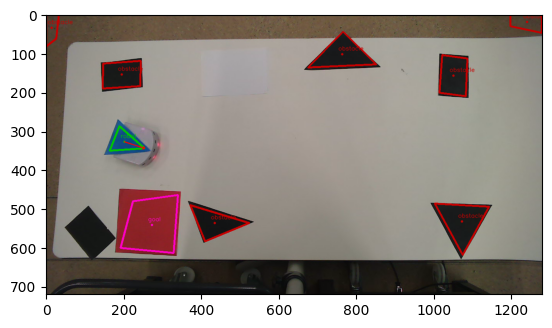

In [2]:
CALIBRATION_DISTANCE = 700


video_capture = cv2.VideoCapture(0,cv2.CAP_DSHOW)
cv_successful, _, robot, _, frame = cv_start(video_capture, show_image= True, exposure=-8)
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

robot[0:2] = invert_coordinates(robot[0:2])
robot[0:2] = pixel_to_metric(np.array([robot[0], robot[1]]))

# kalman variables 
P = 5000*np.eye(3)
x = x_predicted = np.array([[robot[0]],[robot[1]],[robot[2]]])
z = np.array([[0],[0],[0]])
u = np.array([[0],[0]])
previous_time = 0

speed_l = 0
speed_r = 0
teta = 0
goalx = robot[0] + CALIBRATION_DISTANCE
goaly = robot[1]

start_time = time.time()

while True:
#   step 1: get the image, detect the robot, and get the position
    camera_available, frame = video_capture.read()
    position_measure = []
    if camera_available == True:
        position_measure, position_contour, proccessed_framed = computer_vision(frame, 'robot', False)
        # cv has detected the robot, we can use the position
        if len(position_measure) == 1:
            robot_detected = True
            position_measure = position_measure[0]

            if position_measure is not None:                    
                _, theta_measure = get_robot_position(frame, position_measure, position_contour)
                theta_measure = round(-theta_measure, 4)
                position_measure = invert_coordinates(position_measure)
                position_measure = pixel_to_metric(position_measure)
                [kx, ky, kteta] = [position_measure[0], position_measure[1], theta_measure]
                measurement = np.array([kx, ky, kteta])
            else:
                robot_detected = False
        else:
        # robot not detected, we use kalman
            robot_detected = False

    if camera_available == False or robot_detected == False:
        measurement = np.array([0,0,0])         # CHECK WHY 0,0,0            
    
    
    z = np.array([[measurement[0]], [measurement[1]], [measurement[2]]])
    previous_time, x, P, x_predicted = kalman_filter(robot_detected, x, u, z, P , previous_time)
    pred_x, pred_y, pred_teta = x
    
    
    #dist = distance (goalx, goaly, pred_x, pred_y)
    dist = distance (goalx, 0, pred_x, 0)
    print(dist)
    teta = math.atan2((goaly - pred_y), (goalx - pred_x)) #change angle according to kalman

    current_time = time.time()
    if (dist < MIN_DIST or current_time - start_time > 10) :
        motors(0, 0)
        break
    else :
        angle =  wrap_angle((teta - pred_teta) % (2*np.pi))

        #speed_l, speed_r = controller(angle)
        speed_l, speed_r = 50, -50

    u = np.array([[speed_l],[speed_r]]) / ROBOT_SPEED_TO_MM
    motors(speed_l, speed_r)
    
    if robot_detected == False:
        camera_data.append([camera_data[0][-1], camera_data[1][-1], camera_data[2][-1]])
    else:
        camera_data.append([kx, ky, kteta])

    kalman_data.append([pred_x, pred_y, pred_teta])

end_time = time.time()
motors(0, 0)
print("Time taken: ", end_time - start_time)

print("Start : ", camera_data[0], "End : ", camera_data[-1])
print("Speed : ", CALIBRATION_DISTANCE/(end_time - start_time), "mm/s")

In [5]:
cam_copy = np.array(camera_data)
kal_copy = np.array(kalman_data)


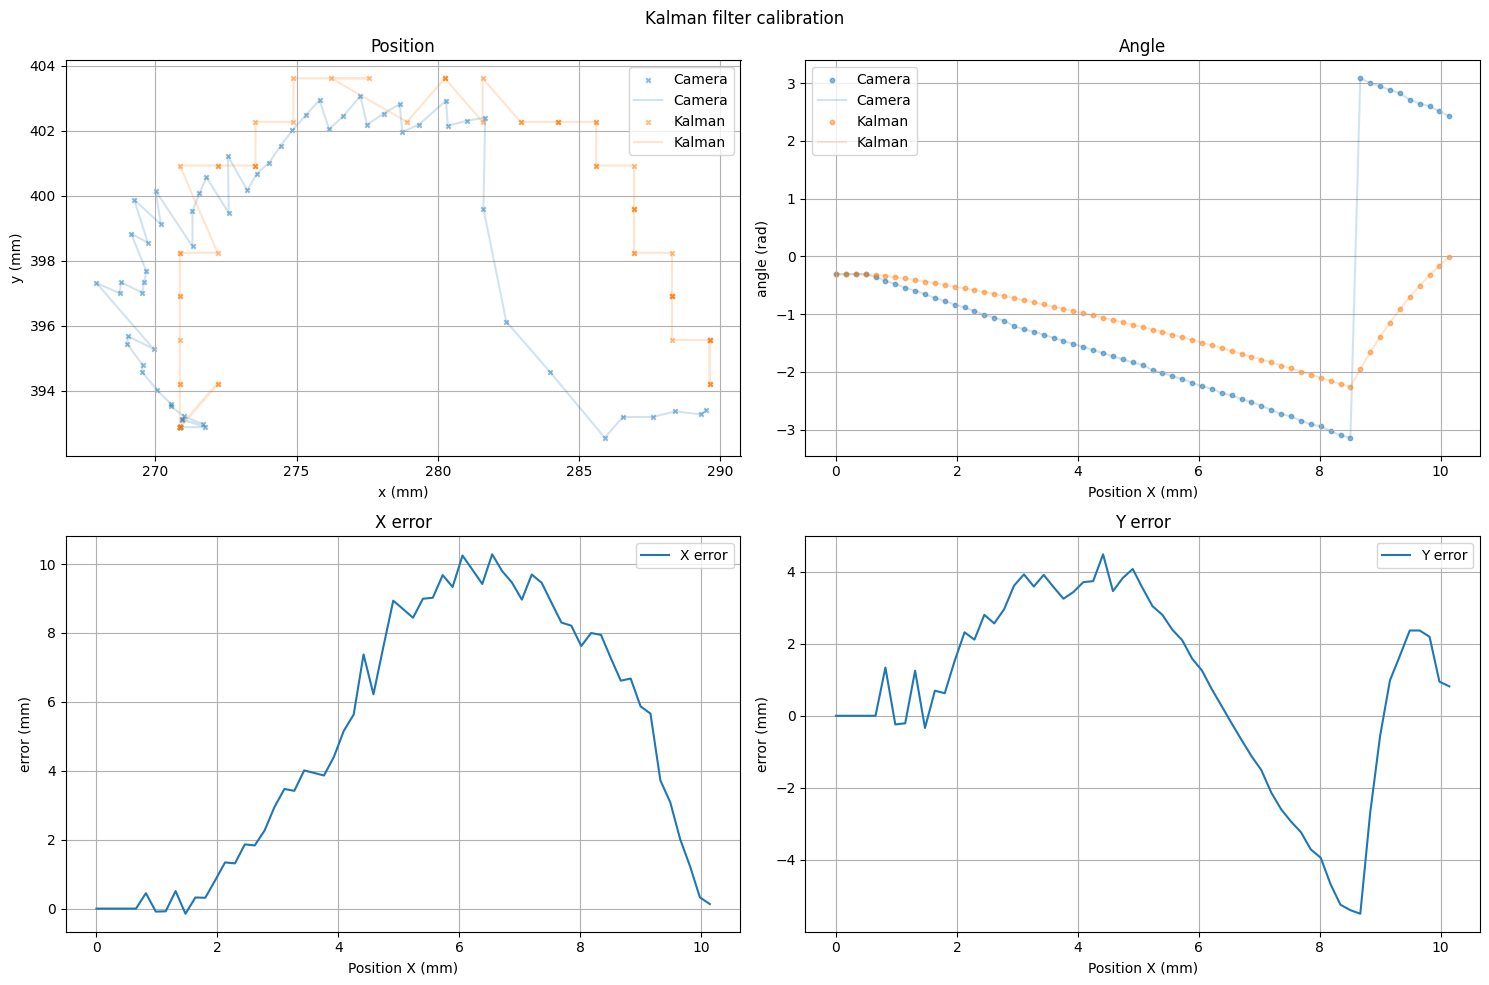

In [6]:
motors(0, 0)

# plot the position of the robot and the angle of the robot side by side

fig, ax = plt.subplots(2, 2, figsize = (15, 10))
time_axis = np.linspace(0, end_time - start_time, len(camera_data))
fig.suptitle('Kalman filter calibration')
ax[0,0].scatter(kal_copy[:,0], kal_copy[:,1], label='Camera', marker='x', s=10, alpha=0.5)
ax[0,0].plot(kal_copy[:,0], kal_copy[:,1], label='Camera', alpha=0.2)
ax[0,0].scatter(cam_copy[:,0], cam_copy[:,1], label='Kalman', marker='x', s=10, alpha=0.5)
ax[0,0].plot(cam_copy[:,0], cam_copy[:,1], label='Kalman', alpha=0.2)
ax[0,0].set_title('Position')
ax[0,0].set_xlabel('x (mm)')
ax[0,0].set_ylabel('y (mm)')
ax[0,0].grid()
ax[0,0].legend()
ax[0,1].scatter(time_axis, cam_copy[:,2], label='Camera', s = 10, alpha=0.5)
ax[0,1].plot(time_axis, cam_copy[:,2], label='Camera', alpha=0.2)
ax[0,1].scatter(time_axis, kal_copy[:,2], label='Kalman', s = 10, alpha=0.5)
ax[0,1].plot(time_axis, kal_copy[:,2], label='Kalman', alpha=0.2)
ax[0,1].set_title('Angle')
ax[0,1].set_xlabel('Position X (mm)')
ax[0,1].set_ylabel('angle (rad)')
ax[0,1].legend()
ax[0,1].grid()

#plot x position error
ax[1,0].plot(time_axis, (cam_copy[:,0] - kal_copy[:,0,0]), label='X error')
ax[1,0].set_title('X error')
ax[1,0].set_xlabel('Position X (mm)')
ax[1,0].set_ylabel('error (mm)')
ax[1,0].legend()
ax[1,0].grid()
# plot y position error
ax[1,1].plot(time_axis, (cam_copy[:,1] - kal_copy[:,1,0]), label='Y error')
ax[1,1].set_title('Y error')
ax[1,1].set_xlabel('Position X (mm)')
ax[1,1].set_ylabel('error (mm)')
ax[1,1].legend()
ax[1,1].grid()

fig.tight_layout()
